# Grocery and Gourmet Food

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

In [2]:
import findspark
findspark.init()
import pyspark

from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import *
import pyspark.sql.functions as fn
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

<br>

Amazon Data : Collection/Analysis of data from Amazon (Reviews and Metadata of products) associated to the thema : ecology, bio, renewable etc... (see keywords vector)

__Review data__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'reviews' file for a 
chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)

>Features:
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

__Metadata (Product)__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'metadata' file for a chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)


>Features:
- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to



Create a folder named 'data' and store the downloaded json zip file. Then unzip in there to get the json file.

In [3]:
DATA_DIR = 'data/'

<br>



Need to load once the global json. You probably won't be able to store it in parquet directly because some features ('related' or 'categories' e.g) can't be written in a file as it is a specific array with weird names. 
You then to clean first the data and store it to parquet. If you want next to retrieve some deleted features ('related' for example) you better do the filtering and extraction on the cleaned dataset and then merge or filter the global dataset using the new one.

<br>

### Importing meta data
<br>

In [73]:
meta_products = spark.read.json(DATA_DIR+"meta_Grocery_and_Gourmet_Food.json")

In [65]:
meta_products.describe()

DataFrame[summary: string, asin: string, brand: string, description: string, imUrl: string, price: string, title: string]

In [66]:
meta_products.show(n=2)

+----------+-----+--------------------+--------------------+--------------------+-----+-------+--------------------+--------------------+
|      asin|brand|          categories|         description|               imUrl|price|related|           salesRank|               title|
+----------+-----+--------------------+--------------------+--------------------+-----+-------+--------------------+--------------------+
|      null| null|                null|                null|                null| null|   null|                null|                null|
|0700026444| null|[[Grocery & Gourm...|Silverpot Tea, Pu...|http://ecx.images...| null|   null|[,,,,,,,, 620307,...|Pure Darjeeling T...|
+----------+-----+--------------------+--------------------+--------------------+-----+-------+--------------------+--------------------+
only showing top 2 rows



<br>

### Meta data preprocessing

These are the IDs for each feature in order to extract them in some filtering/flatmap functions with spark

Example: lambda r: r[0], r[1] etc...

- asin 0
- brand 1
- categories 2
- description 3
- imUrl 4
- price 5
- related 6
- salesRank 7
- title 8

> The next code will extract the relevant and writtable features. It will then store it into parquet 

In [8]:
# This will extract only the features and turn them into more readable features.
# Filter salesRank = None because this will lead to problems for the writing in parquet
# Features removed : corruptRecord, imURL, related
data_cleaned = meta_products.rdd.filter(lambda r: (r[7] != None ) )  \
                    .flatMap(lambda r: [(r[0], r[1], r[2][0][0], r[3], r[5],r[7]['Grocery & Gourmet Food'],  r[8] )]) \

In [9]:
# Define the StructType to define the DataFrame that we'll create with the previously extracted rdd table
schema = StructType([
    StructField("asin", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("category", StringType(), True),
    StructField("description", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("salesRank", IntegerType(), True),
    StructField("title", StringType(), True)
])

In [10]:
# Transform the RDD data into DataFrame (we'll then be able to store it in Parquet)
datacleaned_DF = spark.createDataFrame(data_cleaned, schema=schema)

In [67]:
# Example of the cleaned data (and association with the created StrucType schema)
datacleaned_DF.show(2)

+----------+-----+--------------------+--------------------+-----+---------+--------------------+
|      asin|brand|            category|         description|price|salesRank|               title|
+----------+-----+--------------------+--------------------+-----+---------+--------------------+
|B001EO5U92| null|Grocery & Gourmet...|Naturally nutriti...| null|   166472|Arrowhead Mills G...|
|B001EO5YMA| null|Grocery & Gourmet...|Cugino's Gourmet ...| null|   355714|Cugino's Gourmet ...|
+----------+-----+--------------------+--------------------+-----+---------+--------------------+
only showing top 2 rows



In [12]:
#Save into parquet to save time in the next times
#datacleaned_DF.write.mode('overwrite').parquet("meta_Grocery_and_Gourmet_Food.parquet")

In [13]:
# Read from the parquet data
datacleaned_DF = spark.read.parquet("meta_Grocery_and_Gourmet_Food.parquet")

In [71]:
# Example to see the structure of data (The StrucType schema is indeed there)
datacleaned_DF.take(1)

[Row(asin='B001EO5U92', brand=None, category='Grocery & Gourmet Food', description="Naturally nutritious. Made with organic rice flour. Wheat free. Gluten free, a special blend. For those of us on gluten free diets, this mix is ideal. Enjoy pancakes hot off the griddle or flavorful muffins from your oven whenever you choose. We're sure you'll agree that we've made it easy and satisfying! From America's heartland to your heart. Arrowhead Mills has been the pioneer and leader in organic baking mixes, grains, cereals and nut butters sine 1960. We believe in nature's abundance and treat food with respect - not chemicals! Capturing the essence if the earth with organically grown ingredients, Arrowhead Mills takes you back to the basics with the best-tasting, most diverse selection of products for home-baked goodness. Made with organic rice flour. Good source of calcium. No preservatives. Made with no genetically engineered ingredients. Certified organic by the Texas Department of Agricultur

Now that we created the new dataset here are the features ID of this new one.

These are the IDs for each feature in order to extract them in some filtering/flatmap functions with spark
Example: lambda r: r[0], r[1] etc...

- asin 0
- brand 1
- category 2
- description 3
- price 4 
- salesRank 5
- title 6

In [15]:
print("Number of data samples : " + str(datacleaned_DF.rdd.count()) )

Number of data samples : 145854


> We will now extract the data related to our thema : Ecology, Bio, Renewable etc...

In [ ]:
keywords = [" global warming", " solar energy", " recycling ", " pollution ", "solar power", " endangered species", "air pollution", \
" water pollution", " wind energy", " climate change", " wind power", " recycle ", " deforestation", " greenhouse effect", "environment", \
" sustainability ", " natural resources", "alternative energy", " climate ", "global warming", "renewable energy", " ecology", "composting", \
" carbon footprint", " bio ", " biosphere ", " renewable "]

In [16]:
# Filter with title and description not equal to None
# We will then be able to test if those features contains words defined in the keyword vector 
# The keyword vector represents the thema that we want : ecology, bio etc...
filter_products_bio = datacleaned_DF.rdd.filter(lambda r: (r[6] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[6].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) ) 



In [17]:
print("Number of data samples related to ecology/bio/renewable etc... : " + str(filter_products_bio.count()) )

Number of data samples related to ecology/bio/renewable etc... : 2187


<br>

Let's take a look at the proportion of extracted data compared to the full data that was available:

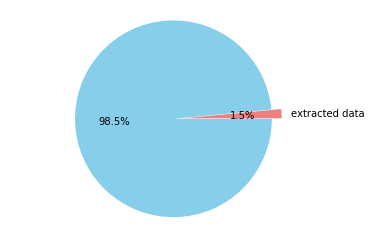

In [45]:
labels = 'extracted data', ''; colors_graph = ['lightcoral', 'skyblue']
plt.pie([filter_products_bio.count(), datacleaned_DF.rdd.count()-filter_products_bio.count()], autopct='%1.1f%%', explode=(0.1, 0), labels=labels, colors=colors_graph)
plt.axis('equal'); plt.show()

Let's take a look at one entry that was extracted:

In [72]:
filter_products_bio.take(1)

[Row(asin='B001EO602S', brand=None, category='Grocery & Gourmet Food', description='The CO2 process delivers a natural, de-caffeinated tea in the purest way possible. Carbon dioxide, acting as a solvent in a super critical state under high-pressure and low temperature, dissolves all active components from natural materials in the leaf. By varying the extraction/separation pressures and temperatures, CO2 makes it possible to selectively extract only the caffeine, leaving the flavor intact. As a solvent, carbon dioxide is non-toxic, odorless, tasteless, germicidal, food-safe and non-combustible and the process does not cause environmental harm.', price=None, salesRank=267957, title='SerendipiTea De-Caff Slim Mint, Chocolate, Vanilla, Rooiboos, Mint &amp; Organic Black Tea, 4-Ounce Boxes (Pack of 2)')]

In [19]:
# Transform the RDD data into DataFrame (we'll then be able work and join with review data)
DF_filter_products_bio = spark.createDataFrame(filter_products_bio)

<br>

### Importing reviews data
<br>

In [20]:
reviews = spark.read.json(DATA_DIR+"reviews_Grocery_and_Gourmet_Food.json")

In [21]:
# To see an example of the data
reviews.take(1)

[Row(asin='0657745316', helpful=[0, 0], overall=5.0, reviewText="No sugar, no GMO garbage, no fillers that come with store bought extracts. This stuff is just amazing. I use it in everything from baking to cooking and even as suggested in my coffee which is saying a lot because I normally do not care for flavored coffee! You cannot go wrong with this. I've ordered from this merchant before, customer satisfaction is their priority and service was quick, shipped right out with tracking even! I'll be buying from GLS Goods again! I won't use any other vanilla!", reviewTime='10 11, 2013', reviewerID='A1ZQZ8RJS1XVTX', reviewerName='gsxrgirl', summary="Best vanilla I've ever had", unixReviewTime=1381449600)]

These are the IDs for each feature in order to extract them in some filtering/flatmap functions with spark

Example: lambda r: r[0], r[1] etc...

- asin 0
- helpful 1
- overall 2
- reviewText 3
- reviewTime 4
- reviewerID 5
- reviewerName 6 
- summary 7 
- unixReviewTime 8

In [22]:
#Save into parquet to save time in the next times
reviews.write.mode('overwrite').parquet("reviews_Grocery_and_Gourmet_Food.parquet")

In [23]:
# Read from the parquet data
reviews = spark.read.parquet("reviews_Grocery_and_Gourmet_Food.parquet")

In [24]:
print("Number of reviews : " + str(reviews.rdd.count()) )

Number of reviews : 1297156


__Join Reviews and Metadata__ 

We will now join the metadata and review dataset using the product ID. Then we'll have the reviews for all products concerned. Here we will join with the filtered data containing the products related to the thema 'bio,recycle,ecology' etc... 

Then in each row we will have the product description and the reviews associated

In [25]:
# This way allows no duplicate
review_product_join = DF_filter_products_bio.join(reviews, ['asin'])

In [26]:
print("Number of reviews related to bio/renewable/ecology etc... : " + str(review_product_join.rdd.count()) )

Number of reviews related to bio/renewable/ecology etc... : 22535


In [27]:
# Example of joined data
review_product_join.take(1)

[Row(asin='B000CFJDWY', brand='Late July', category='Grocery & Gourmet Food', description='When we founded Cape Cod Potato Chips, Inc., and Chatham Village Foods, Inc., we dedicated ourselves to making the best tasting all-natural snacks in the world. Today, the greater availability of organic ingredients has allowed us to bring that dedication to a higher level with our new company: Late July Organic Snacks.The ingredients for our new snacks are a throwback to the days before modern agribusiness. Unlike conventional, pesticide-sprayed crops grown for high yields rather than flavor, organic crops are fragile and expensive, but the payoff is immense: superior flavor, peace of mind, and a cleaner, safer environment.Our recipes are inspired by a bygone era as well. Through our snacks, we hope to perpetuate the tradition of the small, local 19th-century snack maker that used to be found all across the country.', price=43.38999938964844, salesRank=6472, title='Late July Organic Classic Rich

In [28]:
def minUnixTime(accum, n):
    if(accum < n):
        return accum
    else:
        return n

In [29]:
import pyspark.sql.functions as sqlf

In [30]:
firstreview = review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
#.min('unixReviewTime')

In [31]:
firstreview.take(5)

[Row(asin='B000CFJDWY', min(unixReviewTime)=1162771200),
 Row(asin='B000F4SHBU', min(unixReviewTime)=1171238400),
 Row(asin='B000FFGQH6', min(unixReviewTime)=1163203200),
 Row(asin='B000H7D1N4', min(unixReviewTime)=1290729600),
 Row(asin='B001ELL2TM', min(unixReviewTime)=1214956800)]

In [32]:
year_reviews_Pandas = firstreview.toPandas()

In [33]:
year_reviews_Pandas.head()

,asin,min(unixReviewTime)
0,B000CFJDWY,1162771200
1,B000F4SHBU,1171238400
2,B000FFGQH6,1163203200
3,B000H7D1N4,1290729600
4,B001ELL2TM,1214956800


In [34]:
year_reviews_Pandas['Year'] = pd.to_datetime(year_reviews_Pandas['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c6e6550>]],
      dtype=object)

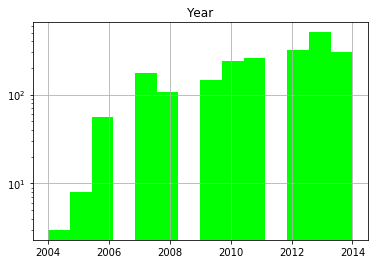

In [35]:
year_reviews_Pandas.hist("Year", color="lime", log=True,bins=14)

Evolution of nb of reviews /year linked to products bio/renwable etc...

In [36]:
globalfirstreview = reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))

In [37]:
globalfirstreview.take(5)

[Row(asin='B0000D1699', min(unixReviewTime)=1341532800),
 Row(asin='B0000D17HO', min(unixReviewTime)=1405036800),
 Row(asin='B0000D89E8', min(unixReviewTime)=1322092800),
 Row(asin='B0000D94PL', min(unixReviewTime)=1367107200),
 Row(asin='B0000DC3QJ', min(unixReviewTime)=1154995200)]

In [38]:
globalyear_reviews_Pandas = globalfirstreview.toPandas()

In [39]:
globalyear_reviews_Pandas['Year'] = pd.to_datetime(globalyear_reviews_Pandas['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117dab048>]],
      dtype=object)

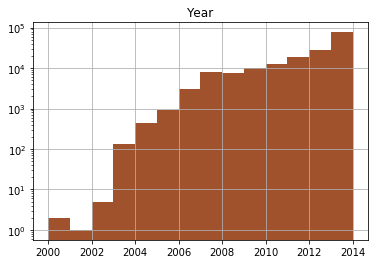

In [40]:
globalyear_reviews_Pandas.hist("Year", log=True, color="sienna", bins = 14)

We can see in the merged dataframe that there is the features from metadata about the products, and the features about the reviews. We will then describe the features ID : 

Example: lambda r: r[0], r[1] etc...

- asin 0
- brand 1
- category 2
- description 3
- price 4
- salesRank 5
- title 6
- helpful 7 
- overall 8
- reviewText 9
- reviewTime 10
- reviewerID 11
- reviewerName 12
- summary 13
- unixReviewTime 14



In [41]:
nbreviews_perproduct=  review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [42]:
nbreviews_DF = spark.createDataFrame(nbreviews_perproduct, ['productID','freq'])

In [43]:
nbreviews_Pandas = nbreviews_DF.toPandas()

Text(0.5,1,'Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..')

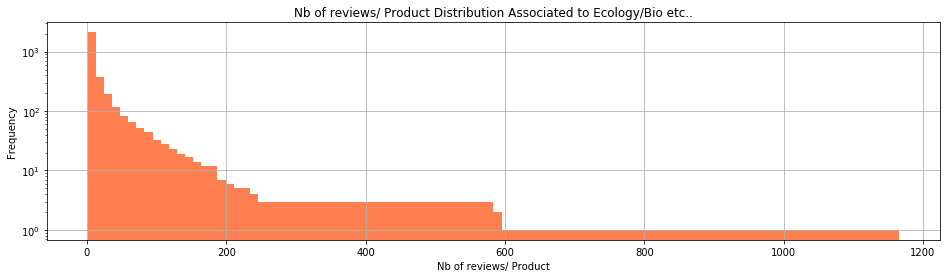

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_size_inches(16,4)

nbreviews_Pandas.hist(log=True, bins = 100, color="coral", cumulative=-1,figsize =(16,4), ax=axes)

axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")